In [1]:
import os
import warnings
from pathlib import Path

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import load_model

from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.saving import custom_object_scope

print(tf.config.list_physical_devices('GPU'))

warnings.simplefilter('ignore')
plt.style.use('ggplot')

plt.rc(
    'figure',
    autolayout=True,
    figsize=(11,4)
)

plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=20,
    titlepad=10
)

2024-01-04 12:26:20.337487: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 12:26:20.337543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 12:26:20.338901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 12:26:20.347857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 12:26:21.923005: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-04 12:26:22.899912: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-04 12:26:23.000007: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-04 12:26:23.000408: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

#### Utils

In [2]:
def split_series(dataframe,n_past,n_future):
    series = dataframe.values
    X,y = list(),list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future    
        if future_end > len(series):
            break
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)

    return np.array(X),np.array(y)

'''Function for making sequences (blocks) of test and train data'''
def building_data_sequences(data_X,data_Y, timesteps): #timesteps means how many days we consider for each block

    X=[]
    y_MPNxP = []
    for i in range(len(data_X)-timesteps+1):  #how it works: every timesteps (e.g. 10 days) a block is constituted and for each block data and true values are stored
        X.append(data_X[i:(i+timesteps),:])
        y_MPNxP.append(data_Y[i+timesteps-1])
    return np.array(X), np.array(y_MPNxP)


def custom_loss_function(attenuated_padding_value):

  def padding_loss_function(y_true, y_pred):

    y_pred = tf.multiply(y_pred, attenuated_padding_value) #this is the multiplication between the predictions and the attenuated_padding_value

    squared_difference = tf.square(y_true - y_pred)

    return tf.reduce_mean(squared_difference, axis=-1) #mse

  return padding_loss_function


def plot_model_history(history: pd.DataFrame):
   ax = history['loss'].plot()
   history.plot(ax=ax)
   plt.show()   

#### Config

In [3]:
ROOT = Path('/home/ubuntu/LTM_Bot/LTM-Long-short_Term_Memory.Bot-API_0.00')
DATA = ROOT / 'data'
MODELS = ROOT / 'models'

FEATURES = ['OPCP','HPCP','LPCP','CPCP','ACPCP','VTCP']
TARGET = 'MPN5P'

TRAIN = True

'''Model parameters: in order to understand, consult the original documentation (case_version_cat Tab) '''
n_epochs = 100
batch = 64

'''These are the exponent used to define the number of nodes for each layer'''
twoexp_nodes_number_layer_1 = 7
twoexp_nodes_number_layer_2 = 10
twoexp_nodes_number_layer_3 = 7
twoexp_nodes_number_layer_4 = 6
twoexp_nodes_number_layer_5 = 0

lr=0.0005 #learning rate

max_iterations =1#maximum number of iterations for the while loop (we will ee later in the code)
precision = 0.00000000001 #this precision is related to the quality of the compound_run_term value we want to obtain (that is representative of the quality of the model)
attenuation_factor = 0.75 #it us used in the computation of the attenuated_padding_value (see custom_loss_function)
attenuated_padding_value = 1
model_case_version_main_target_code = '5'

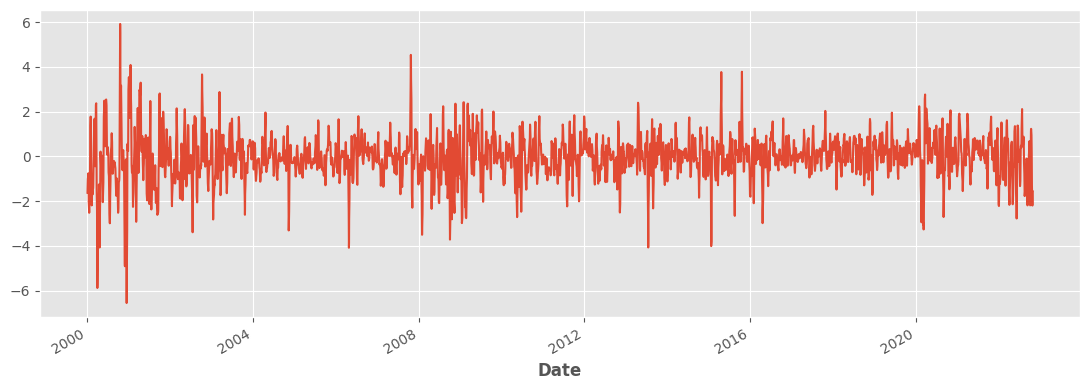

In [4]:
plot_target = True

dataframe = pd.read_csv(DATA / 'pretreated/msft_pretreated_train_20221028.csv', 
                        index_col='Date', 
                        usecols=['Date','OPCP','HPCP','LPCP','CPCP','ACPCP','VTCP', 'MPN5P'])

dataframe.index = pd.to_datetime(dataframe.index)

if plot_target:
    dataframe[TARGET].plot()
    plt.show()

#### Train Test Split

In [5]:
plot_train_val = False

train,validation = train_test_split(dataframe,test_size=0.20, shuffle=False)
if plot_train_val:
    ax = train[TARGET].plot()
    validation[TARGET].plot(ax=ax)
    plt.show()


train_features, train_target = train[FEATURES], train[TARGET]
validation_features, validation_target = validation[FEATURES], validation[TARGET]

print(f'Train features shape: {train_features.shape} Train target shape: {train_target.shape}')
print(f'Validation features shape: {validation_features.shape} Train target shape: {validation_target.shape}')

Train features shape: (4595, 6) Train target shape: (4595,)
Validation features shape: (1149, 6) Train target shape: (1149,)


#### Create Input Sequences

In [6]:
train_features = train_features.to_numpy(dtype='float64')
train_target = train_target.to_numpy(dtype='float64')
validation_features = validation_features.to_numpy(dtype='float64')
validation_target = validation_target.to_numpy(dtype='float64')

X_train, y_train = building_data_sequences(train_features,train_target,timesteps=20)
X_val, y_val = building_data_sequences(validation_features,validation_target, timesteps=20)

input_shape=((X_train).shape[1],(X_train).shape[2])
print("Input shape obtained is:",input_shape)

Input shape obtained is: (20, 6)


#### Define and Compile the Model

In [7]:
clear_session()

model = Sequential()

model.add(LSTM(2**twoexp_nodes_number_layer_1,input_shape=input_shape,return_sequences=True))
model.add(LSTM(2**twoexp_nodes_number_layer_2, return_sequences=True))
model.add(LSTM(2**twoexp_nodes_number_layer_3))
model.add(Dense(2**twoexp_nodes_number_layer_4))
model.add(Dense(int(model_case_version_main_target_code)+1))

model.compile(optimizer=Adam(learning_rate=lr), loss=custom_loss_function(attenuated_padding_value))
model.summary()

2024-01-04 12:26:23.636865: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-04 12:26:23.637262: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-04 12:26:23.637557: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 20, 1024)          4722688   
                                                                 
 lstm_2 (LSTM)               (None, 128)               590336    
                                                                 
 dense (Dense)               (None, 64)                8256      
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 20, 1024)          4722688   
                                                        

In [9]:
if TRAIN:
    history = model.fit(X_train, y_train, batch_size=batch, epochs=n_epochs, validation_data=(X_val,y_val),verbose=2)
    df_history = pd.DataFrame(history.history, columns={'loss': 'train_loss', 'val_loss': 'val_loss'})

    model.save(MODELS / f'ltm_msft_pretreated_lmb002_{TARGET}/lmb002_model.h5')
    df_history.to_csv(MODELS / f'ltm_msft_pretreated_lmb002_{TARGET}/lmb002_model_history.csv', index=False)
else:        
    model = load_model(MODELS / f'ltm_msft_pretreated_lmb002_{TARGET}/lmb002_model.h5',compile=False)
    df_history = pd.read_csv(MODELS / f'ltm_msft_pretreated_lmb002_{TARGET}/lmb002_model_history.csv')

plot_model_history(df_history)

2024-01-04 12:28:46.053198: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB (rounded to 16777216)requested by op StatelessRandomNormalV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-01-04 12:28:46.053234: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-01-04 12:28:46.053249: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 25, Chunks in use: 25. 6.2KiB allocated for chunks. 6.2KiB in use in bin. 412B client-requested in use in bin.
2024-01-04 12:28:46.053257: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-01-04 12:28:46.053265: 

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomNormalV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[4096,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomNormalV2] name: 